## Building a Retrieval-Augmented Generation (RAG) System
#### Alan García Zermeño
14/11/2024

### Section 5: Final Report
#### This section includes:
- A comprehensive final report.
- All relevant code files and scripts.

In [25]:
import pandas as pd
import nltk
import http.client
import json
import google.generativeai as genai
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from tqdm.notebook import tqdm
from openai import OpenAI
import time
import textwrap
import sys
import os

# Import script modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../Scripts')))
from datacleaner import data_cleaner
from RetrievalSystemWeb import evaluator, generGemini, CRAG

[nltk_data] Downloading package punkt to /home/alan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data report

- The DS_exam database consists of a set of queries related to questions and answers regarding the Keytruda treatment, along with other data that may be useful for potential filtering.

- The column names do not align in the same row, and there are 'nan' values.

- To achieve this, we will reload the database, appropriately naming each column.

In [3]:
data_dir = "../Dataset/DS_exam.xlsx"
data = pd.read_excel(data_dir, skiprows = [0,1], header = None)     #Take only usefull rows
col = pd.concat([data.iloc[0][:5], data.iloc[1][5:]])               #Organize data columns
data = data[2:]
data.reset_index(drop=True, inplace=True)                     
data.columns = col                                                  #Update data columns
data.head()   

,Country,Requester_Type,Product,Indication,Question,Channel,Date_Time_Open,Date_Time_Closed,Answer/Solution
0,UK,HCP,Keytruda,NSCLC,What are the common side effects of Keytruda?,email,2023-06-27 17:00:00,2023-07-21 18:00:00,"Common side effects include fatigue, nausea, a..."
1,US,Researcher,Keytruda,NSCLC,Can Keytruda cause immune-related adverse effe...,email,2023-06-08 08:00:00,2023-07-06 12:30:00,"Yes, Keytruda can cause immune-related adverse..."
2,UK,HCP,Keytruda,NSCLC,Is Keytruda safe for pregnant women?,call,2023-03-06 04:00:00,2023-04-19 15:00:00,Keytruda is not recommended for use during pre...
3,UK,Researcher,Keytruda,NSCLC,What should patients report immediately while ...,email,2023-02-05 10:30:00,2023-03-05 06:00:00,Patients should report any new or worsening sy...
4,US,Researcher,Keytruda,NSCLC,Are there any known interactions between Keytr...,call,2023-03-14 09:30:00,2023-04-16 18:30:00,"Yes, Keytruda can interact with steroids and c..."


Broadly speaking, the database consists of a set of 50 queries from 49 Question/Answer pairs ans 1 question without answer concerning the Keytruda treatment. Using our DataLoader script we can extract all the database questions, all the answers and the complete clean corpus (Questions + Answers)  

In [5]:
corpus,questions,answers = data_cleaner()

49 Question/Answer pairs extracted!


### CRAG

Since we will implement a complex CRAG system, we are going to use a very simple and lightweight library as a first naive approach to information retrieval given a query: rank_bm25. The get_top_n function is capable of rank the most relevant documents of a tokenized corpus given a tokenized query. In this case we print the 3 most relevant Q/A pairs given the query *Effects of Keytruda in treating cancer?*. 

In [7]:
doc_tokens = [word_tokenize(doc.lower()) for doc in corpus]
bm25 = BM25Okapi(doc_tokens)
query_tokens = word_tokenize("Does Keytruda work for all types of cancer?".lower())
top_docs = bm25.get_top_n(query_tokens, corpus,n=3)
for d in top_docs[:3]: print(d)

Question: Does Keytruda work for all types of cancer?:
 Answer: Keytruda is most effective in cancers that express PD-L1 and in a genetic background favorable to immune therapy.
Question: How does Keytruda work in combination with other therapies for NSCLC?:
 Answer:  Keytruda works synergistically with chemotherapy and other immunotherapies to enhance the immune response against cancer cells, often leading to improved outcomes.
Question: How long does it take to see the effects of Keytruda in treating cancer?:
 Answer: Some patients may see effects as early as 2 to 3 months into the treatment.


We are going to implement an adaptation of CRAG based on [Corrective Retrieval Augmented Generation paper](https://arxiv.org/abs/2401.15884)

But we are going to make some fixes for make it even more flexible and light: 
- We will use BM250 as the basic retrieval.
- We will use the free Gemini API to use Gemini-pro Llm like a *corrector* model.
- Gemini will jugdge if the retrieved database answer is relevant to an input query.
- If not, we will perform web search for improving the document retrieval. (This will be implemented in section 6)

The original system shows this structure:
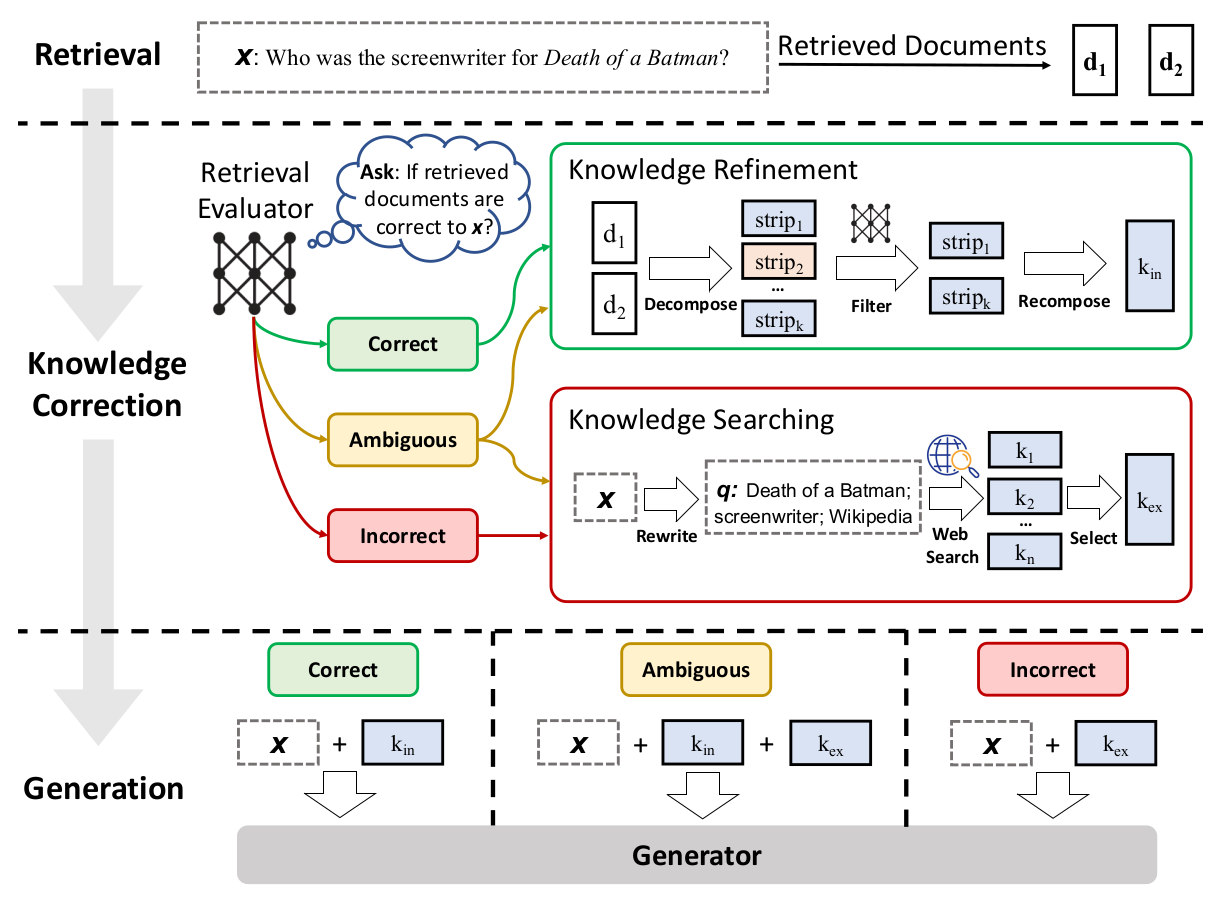


I chose to implement Corrective Retrieval Augmented Generation (CRAG) over the other techniques because is flexible ans suitable for varios aplications ans domains. In this case, I decide to adapt the CRAG to my hardware performance, adding a LLM to the evaluator for my retriever, I think this option is the best for a simple database like the provided given my hardware settings and working locally. Compared to the other techniques, CRAG integrates error correction, making it a superior choice for producing precise and reliable responses.

- Lets use Gemini-pro Llm as a corrective model. This is a powerfull model, free and easy for locally use.
- If we had more memory and hardware power we could download and use a HuggingFace model like Llama 2 instead of Gemini as a corrector.
- We will need an API key, you can get one in: https://ai.google.dev/gemini-api/docs/api-key.
- Then, save it in the 'Gemini.txt' file in the APIS directory. 
- **Please only paste the API key**.

In [8]:
with open("../APIS/Gemini.txt", 'r') as file: apiG = file.readline().strip()
genai.configure(api_key=apiG)
model = genai.GenerativeModel('gemini-pro')
safety= {'HARASSMENT':'block_none','HARM_CATEGORY_HATE_SPEECH':'block_none',
                  'HARM_CATEGORY_HARASSMENT':'block_none','HARM_CATEGORY_SEXUALLY_EXPLICIT':'block_none',
                  'HARM_CATEGORY_DANGEROUS_CONTENT':'block_none'}

The *evaluator* function will be our retrieval system with the already specified settings. 

In [9]:
def evaluator(query,corpus,answers,safety = None):
    """ Evaluates whether the corpus is relevant to the query
    Args:
        query:      String query to evaluate
        corpus:     Documents array to search for information
        answers:    Answers array from the corpus without the questions
        safety:     Dic safety setting for Gemini generation
    """

    #Prompt instructions for evaluate the query-answer pair
    instructions = """Does the following document have exact information to answer the following query?
    Please choose one of the two possible options: Yes, or No.
    """

    #Extract the most relevant document using bm25
    query_tokens = word_tokenize(query.lower())
    top_docs = bm25.get_top_n(query_tokens, corpus, n=1)
    question = top_docs[0]                                  #Most relevant document
    indx = corpus.index(question)                           #Most relevant document index
    context = answers[indx]                                 #Most relevant answer

    #Final prompt for Gemini and Evaluation
    prompt = f"{instructions}\n\n\
        Question: {query}\n\n\
        Document: {context}\n\n\
        Evaluation: [Select one: Yes, No]:"
    response = model.generate_content(prompt,safety_settings=safety)

    print(prompt)
    print(response.text)
    return context if response.text == "Yes" else False

Lets test some examples. For each query test, we print the complete used prompt and the Gemini response. The Gemini task is to evaluate the retrieved response given a query. The evaluator should return the asnwer if its a clear answer for the query and bool variable False if is not. Afert, we are going to adapt web search for answer the questions that the system retriever cant found in the database.

In [10]:
evaluator("Keytruda purpose of the treatment",corpus,answers,safety)
evaluator("What is Keytruda?",corpus,answers,safety)
evaluator("How effective is Keytruda in treating non-small cell lung cancer?",corpus,answers,safety)

Does the following document have exact information to answer the following query?
    Please choose one of the two possible options: Yes, or No.
    

        Question: Keytruda purpose of the treatment

        Document: Approximately 40% of melanoma patients respond positively to Keytruda treatment.

        Evaluation: [Select one: Yes, No]:
No
Does the following document have exact information to answer the following query?
    Please choose one of the two possible options: Yes, or No.
    

        Question: What is Keytruda?

        Document: Keytruda is administered as an intravenous infusion over 30 minutes.

        Evaluation: [Select one: Yes, No]:
No
Does the following document have exact information to answer the following query?
    Please choose one of the two possible options: Yes, or No.
    

        Question: How effective is Keytruda in treating non-small cell lung cancer?

        Document: Keytruda has shown to improve survival rates significantly in non-small ce

'Keytruda has shown to improve survival rates significantly in non-small cell lung cancer patients with PD-L1 expression.'

### Generaton component

We first will refer to our document retrieval system. The evaluator function receives the query to be evaluated, the corpus, and the responses from the corpus. It will return the most relevant response to the query if our system determines that it clearly answers the query; otherwise, it will return a boolean variable: *False*.

In [11]:
query = "How effective is Keytruda in treating non-small cell lung cancer?"
context = evaluator(query,corpus,answers)
print(context)

Does the following document have exact information to answer the following query?
    Please choose one of the two possible options: Yes, or No.
    

        Question: How effective is Keytruda in treating non-small cell lung cancer?

        Document: Keytruda has shown to improve survival rates significantly in non-small cell lung cancer patients with PD-L1 expression.

        Evaluation: [Select one: Yes, No]:
Yes
Keytruda has shown to improve survival rates significantly in non-small cell lung cancer patients with PD-L1 expression.


The fundamental idea of integrating the generative language model into the information retrieval system is to provide it with the context authorized by the evaluator model and ask it to provide its own response to the query within the context of the authorized response.
Given that in the previous query, our evaluator model found an appropriate document and returned it in the 'context' variable, an example of a prompt to the generative model would be as follows:

In [12]:
prompt = f"""
Please generate an informative and concise response to the following query.
Use the provided context information to ensure your response is accurate and relevant.

Context: {context}

Query: {query}

Response: 
"""

The ideal approach would be to use a different and more advanced model as the generative model. We will use the GPT API for using GPT-4o.

- We will need an API key, so you can get one in: https://platform.openai.com/api-keys.
- Then, save it in the 'gpt.txt' file in the APIS directory. 
- **Please only paste the API key**.

In [14]:
from openai import OpenAI

with open("../APIS/gpt.txt", 'r') as file: apik = file.readline().strip()
client = OpenAI(api_key = apik)

In [17]:
model = "gpt-4o"
prompt = f"""
Please generate an informative and concise response to the following query.
Use the provided context information to ensure your response is accurate and relevant.

Context: {context}
"""
if context:
  completion = client.chat.completions.create(
        model=model,
        messages=[
        {"role": "system", "content": prompt},
        {"role": "user", "content": query}
        ],
        max_tokens=120
      )
  print(textwrap.fill(completion.choices[0].message.content))
else:
    print("I cant answer this prompt due a lack of proper information in the database")

Keytruda (pembrolizumab) has demonstrated significant efficacy in
treating non-small cell lung cancer (NSCLC), particularly for patients
whose tumors express the PD-L1 protein. Clinical trials have shown
that Keytruda can significantly improve survival rates in these
patients. It works by blocking the PD-1/PD-L1 pathway, thereby
enhancing the immune system's ability to target and destroy cancer
cells. This makes Keytruda a vital treatment option for eligible NSCLC
patients, offering them a better prognosis compared to traditional
therapies.


Lets try some examples calling the Retrieval System script. Remember, if the answer is not found by the retrieval system in the database, the generative model should not return a response until we implement the web search system. 

In [21]:
query = "How long does it take to see the effects of Keytruda in treating cancer?"
CRAG(query,corpus,answers,safeURLs=[])

Does the following document have exact information to answer the following query?
    Please choose one of the two possible options: Yes, or No.
    

        Question: How long does it take to see the effects of Keytruda in treating cancer?

        Document: Some patients may see effects as early as 2 to 3 months into the treatment.

        Evaluation: [Select one: Yes, No]:
Yes


GPT RESPONSE:
Patients may start to see effects from Keytruda as early as 2 to 3
months into the treatment. However, response times can vary depending
on the individual's specific condition and overall health. It's
important to regularly consult with your healthcare provider to
monitor progress and adjust the treatment plan as needed.


In [22]:
query = "Can Keytruda be used in combination with other therapies?"
CRAG(query,corpus,answers,client)

Does the following document have exact information to answer the following query?
    Please choose one of the two possible options: Yes, or No.
    

        Question: Can Keytruda be used in combination with other therapies?

        Document: Yes, Keytruda can be used in combination with chemotherapy and other immunotherapies depending on the cancer type.

        Evaluation: [Select one: Yes, No]:
Yes


GPT RESPONSE:
Yes, Keytruda can be used in combination with chemotherapy and other
immunotherapies, depending on the type of cancer. This combination can
sometimes enhance treatment effectiveness by leveraging different
mechanisms to attack cancer cells. Always consult with a healthcare
provider to determine the best treatment plan for your specific
condition.


We can see that indeed when we input a query that the evaluator model authorizes, given that there is a clear answer in the corpus, the generative model (GPT) produces an appropriate and more detailed response to the query. The only thing missing in this system is implementing a web search when the evaluator model does not find an appropriate document in the database, so that we can also receive a response from the evaluator model in these cases. Again, we will implement this in section 6.

- There are answers in the database that do not really offer useful data, for example *40- Question: Can Keytruda cause fatigue in NSCLC patients?: Answer: No detailed information aviable on the given topic.* Fortunately, the evaluator model does not allow these to pass to the generative model.

- A prompt explaining the task had to be added before the query to make it clear to the generative model that it needed to improve the response, because without that explanation, the model often simply generated the response provided in the prompt.

### Web search component

The best method to improve the retrieve system is to add web search when the database dont have an specific answer to a query.

To make web queries we will use a cheap version of Google search API: Serper. We will need the following:
- We will need an API key, so you can get one in: https://serper.dev/api-key.
- Then, save it in the 'serper.txt' file in the APIS directory. 
- **Please only paste the API key**.

The strategy will be to make a web query once the function that evaluates our query determines that there is not enough information in the database to accurately answer our query. Once this occurs, the process will be as follows:

- **Processing**: We will ask Gemini to analyze our query and extract up to four words that describe our question in a format suitable for web search. For example: "*The best football players of 2023*" --> "*best football players 2023*"

- **Query**: This summarized query will be used to call the server API, which will return some useful URLs and snippets.

- **Extraction**: We will use JSON to extract all the snippets and concatenate them into a corpus.

- **Summarization**: Gemini will summarize the corpus into a couple of sentences to answer the query as concretely as possible.

- **Generation**: This summarized query will serve as context for generating the final response by GPT.

So, in the scenario where we require a web search, first, we will design the web query with the help of Gemini.

In [30]:
promptQ = "Summarize this query to a maximum of 4 words to perform an internet search: \nQuery: "
cont = "What is Keytruda?"
queryW = generGemini(promptQ+cont)
print(f"Web Query: {queryW}")

Web Query: Keytruda drug information


Next, we perform the query by calling the API with our key.

In [31]:
with open("../APIS/serper.txt", 'r') as file: apiw = file.readline().strip()
conn = http.client.HTTPSConnection("google.serper.dev")
payload = json.dumps({"q": queryW})
headers = {'X-API-KEY': apiw,'Content-Type': 'application/json'}
conn.request("POST", "/search", payload, headers)
res = conn.getresponse()
res

Then, we extract the snippets using json

In [32]:
data = res.read()
response_dict = json.loads(data.decode("utf-8"))

webCorpus = ""
for sni in response_dict['organic']:
    webCorpus += " "+sni['snippet']
    
print(textwrap.fill(webCorpus[:200])+" ...")

 KEYTRUDA is a prescription medicine used to treat a kind of cancer
called cervical cancer. KEYTRUDA may be used with chemotherapy and
radiation therapy when ... Keytruda (pembrolizumab) is a type of ...


This big information block is going to be summarized by Gemini.

In [33]:
promptZ = f"Summarize this corpus to a maximum of 2 sentences to try to answer ONLY this query: \nCorpus: {webCorpus} \nQuery: {cont} \nResponse: "
response = generGemini(promptZ)
print(textwrap.fill(response))

Keytruda (pembrolizumab) is an immunotherapy drug that helps the
immune system fight cancer by binding to the PD-1 protein on immune
cells and allowing them to better kill cancer cells. It is used to
treat various types of cancer, including cervical cancer, head and
neck squamous cell carcinoma, and other cancers.


The final step is to use this response as context for the final GPT response to our query.

In [34]:
#Define model and prompt
with open("../APIS/gpt.txt", 'r') as file: apik = file.readline().strip()
client = OpenAI(api_key = apik)
model = "gpt-3.5-turbo"


print("IMPORTANT: This information is not extracted from the official database")

prompt = f"""
    Please generate an informative and concise response to the following query.
    Use the provided context information to ensure your response is accurate and relevant.

    Context: {context}
    """

completion = client.chat.completions.create(
                model=model,
                messages=[
                {"role": "system", "content": prompt},
                {"role": "user", "content": query}
                ],
                max_tokens=120
            )
print("\n\nGPT RESPONSE:")
print(textwrap.fill(completion.choices[0].message.content))

IMPORTANT: This information is not extracted from the official database


GPT RESPONSE:
Yes, Keytruda (pembrolizumab) can be used in combination with other
therapies for the treatment of non-small cell lung cancer.
Combinations of Keytruda with chemotherapy, targeted therapy, or other
immunotherapy drugs may be recommended by healthcare providers to
enhance treatment outcomes. However, it is crucial to consult with a
healthcare provider to determine the most appropriate and effective
treatment plan based on individual circumstances and medical history.


#### Adding security

Data on the internet is not always reliable. Various strategies can be employed to maintain the reliability of responses. Among these, we could use a model with fine-tuning on real data to serve as a filter to avoid false information. However, the simplest approach is to use only trustworthy websites. In this case, we could compile a list of trusted URLs, such as "keytruda.com," to extract snippets solely from that domain. We would simply need to modify the extraction code slightly:

In [35]:
secureURLs = ['keytruda.com','wikipedia']                           #list of trusted URLs
webSecureCorpus = ""
for sni in response_dict['organic']:
    for urls in secureURLs:
        if urls in sni["link"]:
            webSecureCorpus += " "+sni['snippet']
    
print(textwrap.fill(webSecureCorpus))

 KEYTRUDA is a prescription medicine used to treat a kind of cancer
called cervical cancer. KEYTRUDA may be used with chemotherapy and
radiation therapy when ...


The complete script CRAG() was programmed in the "RetrievalSystemWeb.py" file, and we can easily call it by passing it our query, our corpus, our responses and the list of websites with which we want to search for information if the evaluation model requires it.

In [36]:
query = "What is Keytruda?"
CRAG(
    query = query,
    corpus = corpus,
    answers = answers,
    safeURLs = ['keytruda.com','wikipedia']
    )

Does the following document have exact information to answer the following query?
    Please choose one of the two possible options: Yes, or No.
    

        Question: What is Keytruda?

        Document: Keytruda is administered as an intravenous infusion over 30 minutes.

        Evaluation: [Select one: Yes, No]:
No
IMPORTANT: This information is not extracted from the official database
Web Query: Keytruda information
 KEYTRUDA is a prescription medicine used to treat a kind of cancer
called head and neck squamous cell cancer (HNSCC). KEYTRUDA may be
used with the chemotherapy ... Pembrolizumab, sold under the bran


GPT RESPONSE:
Keytruda (pembrolizumab) is a prescription medicine that is primarily
used as an immunotherapy to treat various types of cancer, including
head and neck squamous cell carcinoma (HNSCC), melanoma, and lung
cancer. It works by targeting and blocking a protein called PD-1 on
the surface of cancer cells, thereby enhancing the body's immune
response to fight t

The following is an example where the evaluator model found pertinent information in the database and didnt perform a search web. 

In [37]:
query = "What are Keytruda side effects?"
CRAG(
    query = query,
    corpus = corpus,
    answers = answers,
    safeURLs = ['keytruda.com']
    )

Does the following document have exact information to answer the following query?
    Please choose one of the two possible options: Yes, or No.
    

        Question: What are Keytruda side effects?

        Document: Common side effects include fatigue, nausea, and skin rash.

        Evaluation: [Select one: Yes, No]:
Yes


GPT RESPONSE:
Keytruda, also known as pembrolizumab, can cause several side effects.
Common side effects include fatigue, nausea, and skin rash. If you
experience any severe or persistent symptoms, it's important to
consult with your healthcare provider.


The following are examples where the evaluator model didnt found pertinent information in the database and did perform a search web.

In [40]:
query = "Who invented keytruda?"
CRAG(
    query = query,
    corpus = corpus,
    answers = answers,
    safeURLs = ['keytruda.com','wikipedia']
    )

Does the following document have exact information to answer the following query?
    Please choose one of the two possible options: Yes, or No.
    

        Question: Who invented keytruda?

        Document: Keytruda is administered as an intravenous infusion over 30 minutes.

        Evaluation: [Select one: Yes, No]:
No
IMPORTANT: This information is not extracted from the official database
Web Query: Inventor of Keytruda
 Pembrolizumab, sold under the brand name Keytruda, is a humanized
antibody used in cancer immunotherapy that treats melanoma, lung
cancer, head and neck cancer, ...


GPT RESPONSE:
The provided corpus does not contain information about the inventor of
Keytruda. However, Keytruda (pembrolizumab) was developed by the
pharmaceutical company Merck & Co. Keytruda is an immunotherapy drug
that works by blocking the PD-1/PD-L1 pathway, thereby allowing the
immune system to better attack cancer cells. If you need more detailed
information about its development or the in

In [39]:
query = "keytruda and chemotherapy are the same?"
CRAG(
    query = query,
    corpus = corpus,
    answers = answers,
    safeURLs = ['keytruda.com','wikipedia']
    )

Does the following document have exact information to answer the following query?
    Please choose one of the two possible options: Yes, or No.
    

        Question: keytruda and chemotherapy are the same?

        Document:  Yes, Keytruda demonstrated superior efficacy in terms of overall survival and progression-free survival compared to chemotherapy in NSCLC patients.

        Evaluation: [Select one: Yes, No]:
No
IMPORTANT: This information is not extracted from the official database
Web Query: Keytruda vs Chemotherapy
 KEYTRUDA reduced the risk of cancer spreading, growing, or getting
worse by 42% compared to chemotherapy. Half of the patients on
KEYTRUDA 2 mg/kg given every 3 ... KEYTRUDA with chemotherapy reduced


GPT RESPONSE:
No, Keytruda and chemotherapy are not the same. Keytruda
(pembrolizumab) is an immunotherapy drug that works by helping the
immune system recognize and attack cancer cells. Chemotherapy, on the
other hand, uses drugs that target and kill rapidly divid

This last example is very important, since the base document retriever system found an answer that responds affirmatively to our query: "Is keytruda and chemo the same?", however, our evaluator model detects that it is not an appropriate answer to our question and send to the web search. Finally, GPT clearly explains the difference between chemo and keytruda to us by taking information from secure websites.

### CRAG evaluation
(Code for this part of the task is on the CRAG_Evaluation notebook)

For our evaluation task will call a version of our CRAG with web search (check section 6) that will return all the final responses along with the two boolean variables that we will explain later.
The main idea is to use all the questions in our database to evaluate our system, and we will save all the answers in the "_answersRAG_" array.

Important: We use a two-second pass between requests to Gemini so as not to exceed its quota limit.

The "_websbool_" array will save a boolean variable for each call to our CRAG, indicating whether information about pages marked as safe was found (in this case keytruda.com and wikipedia). The other variable "_flag_" is stored in the array "_qbool_" and tells us whether our evaluator model authorized a web search or not for each query.

Then, to evaluate our answers, we will compare them with the official answers in the database for each of the questions. The model you will evaluate will be a version of GPT. The prompt specifically contains the two answers, the question and asks the model to evaluate which of the two is better or if both are equally good.

Then, we run our evaluation test by iteratively passing all the questions and their two answers, and we save the GOT evaluation in the "_bestres_" array.

Finally, we can define our 3 metrics to take into account based on all the responses:

- **Retriever score (RS)**: The percentage of questions for which our retriever model managed to find a correct answer within the same database. Tells us how good our retriever system is.

- **Web search score (WSS)**: On the occasions where the model had to access web search, it tells us the percentage of instances where we were able to obtain information from our secure pages (Wikipedia, Keytruda.com). It tells us how safe our web search is based on which web pages are marked as safe.

- **CRAG score (CRAGS)**: Percentage of questions where CRAG answers were evaluated as "better" than those in the database by our chosen version of GPT. It tells us how much our CRAG improves on the original answers in the database.

**First test**: First we will evaluate our CRAG where **GPT 3.5** is our generating model and we will have **two secure urls**: keytrude.com and wikipedia. The model that will qualify the answers will be **GPT-4o**.

**Second test**: Next, we will evaluate our CRAG where **GPT-4o* is our generating model and we will **not have secure urls**, therefore, we will examine the internet without filters. The model that will qualify the answers will be **GPT-4**.

**Third test**: Next, we will evaluate our CRAG where **GPT-4* is our generating model and we will **not have secure urls**, therefore, we will examine the internet without filters. The model that will qualify the answers will be **GPT-4**.

## Final Results

**Test** | **RS** | **WSS** | **CRAGS** |
|--------- |----------|----------|----------|
| **Fist**    | 81.63%    | 44.44%   | 91.84%   |
| **Second**    | 83.67%    | 100%   | 100%   |
| **Third**    | 81.63%    | 100%   | 75.86   |

### Observations, Conclusions:
- Since no corrections or improvements were made to the retriever system across the three tests, we can define that, on average, our retriever model achieved an **82.31%** success rate. This is a commendable result, which could be significantly enhanced by further enriching the database.

- Our web search was consistently successful when we did not limit ourselves to secure websites only. We found results on secure sites 44.44% of the time when the filter was applied. This could be improved by expanding our list of secure websites.

- Regarding the CRAG metric, we observe that when GPT-3.5 was our generating model, GPT-4 evaluated it with a score of 91%. When GPT-4 generated and was evaluated by itself, the score dropped to 75.86%. However, when GPT-4 generated and was evaluated by GPT-4o, we achieved the highest score. Therefore, we conclude that for this specific test, **GPT-4o is the most effective model to be used as the generating model for our CRAG**.

We add aditional documentation (README and instructions) to the main directory.